In [1]:
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install -q catboost shap boruta category_encoders optuna BorutaShap
from catboost import CatBoostRegressor, Pool, CatBoostClassifier, EShapCalcType, EFeaturesSelectionAlgorithm
!pip install -qU eif
import eif
clear_output()

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, PowerTransformer, RobustScaler, StandardScaler, LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.metrics import classification_report

from scipy.stats import mannwhitneyu, shapiro, probplot
from scipy.stats import chi2_contingency

from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, SMOTENC

from sklearn.cluster import KMeans

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras import regularizers

from statsmodels.tsa.seasonal import seasonal_decompose
from boruta import BorutaPy
import category_encoders as ce
import optuna
from optuna.samplers import TPESampler

In [4]:
np.random.seed(1)
tf.random.set_seed(1)
data_root = r'/content/drive/My Drive/data/weather/rain.csv'
TARGET_NAME_REG = 'RISK_MM'
TARGET_NAME_CLS = 'RainTomorrow'

In [5]:
df = pd.read_csv(data_root)
# (df.duplicated()).astype(int).sum()

In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,01/12/2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,02/12/2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,03/12/2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,04/12/2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,05/12/2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [ ]:
df.describe()  
# seems like all numeric columns have normal distribution, so tranformation is not needed (no shapiro, distplots)
# but in lots of columns may possibly occur outliers

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RISK_MM
count,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,2.360682
std,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,8.477969
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


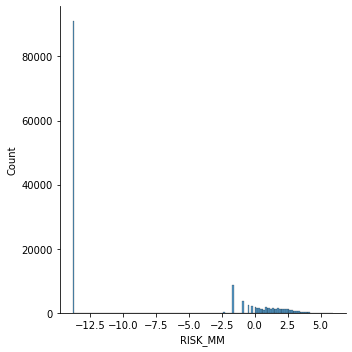

In [ ]:
sns.displot(np.log(df.RISK_MM + 1e-6), bins=150)
plt.show()

In [ ]:
df[df.RISK_MM <= 1].shape

(110316, 24)

In [ ]:
df.describe(include=[np.object])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
count,142193,142193,132863,132180,138415,140787,142193
unique,3436,49,16,16,16,2,2
top,12/01/2017,Canberra,W,N,SE,No,No
freq,49,3418,9780,11393,10663,109332,110316


In [ ]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)
df.set_index('Date', drop=True, inplace=True)

In [ ]:
canberra = df.loc[df.Location == 'Canberra', 'RISK_MM'].values

In [ ]:
result = seasonal_decompose(canberra, model="add", freq=365)

In [ ]:
# we wont use time series

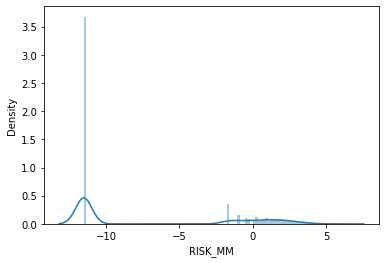

In [ ]:
sns.distplot(np.log(df[TARGET_NAME_REG]+1e-5), bins=100)
plt.show()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142193 entries, 2008-12-01 to 2017-06-24
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm     

In [ ]:
for column in df.select_dtypes(include=[np.object]).columns:
    print(df[column].value_counts(), '='*40, sep='\n')

Canberra            3418
Sydney              3337
Perth               3193
Darwin              3192
Hobart              3188
Brisbane            3161
Adelaide            3090
Bendigo             3034
Townsville          3033
AliceSprings        3031
MountGambier        3030
Ballarat            3028
Launceston          3028
Albany              3016
Albury              3011
PerthAirport        3009
MelbourneAirport    3009
Mildura             3007
SydneyAirport       3005
Nuriootpa           3002
Sale                3000
Watsonia            2999
Tuggeranong         2998
Portland            2996
Woomera             2990
Cobar               2988
Cairns              2988
Wollongong          2983
GoldCoast           2980
WaggaWagga          2976
Penrith             2964
NorfolkIsland       2964
SalmonGums          2955
Newcastle           2955
CoffsHarbour        2953
Witchcliffe         2952
Richmond            2951
Dartmoor            2943
NorahHead           2929
BadgerysCreek       2928


In [ ]:
df.isna().sum()

Location             0
MinTemp            637
MaxTemp            322
Rainfall          1406
Evaporation      60843
Sunshine         67816
WindGustDir       9330
WindGustSpeed     9270
WindDir9am       10013
WindDir3pm        3778
WindSpeed9am      1348
WindSpeed3pm      2630
Humidity9am       1774
Humidity3pm       3610
Pressure9am      14014
Pressure3pm      13981
Cloud9am         53657
Cloud3pm         57094
Temp9am            904
Temp3pm           2726
RainToday         1406
RISK_MM              0
RainTomorrow         0
dtype: int64

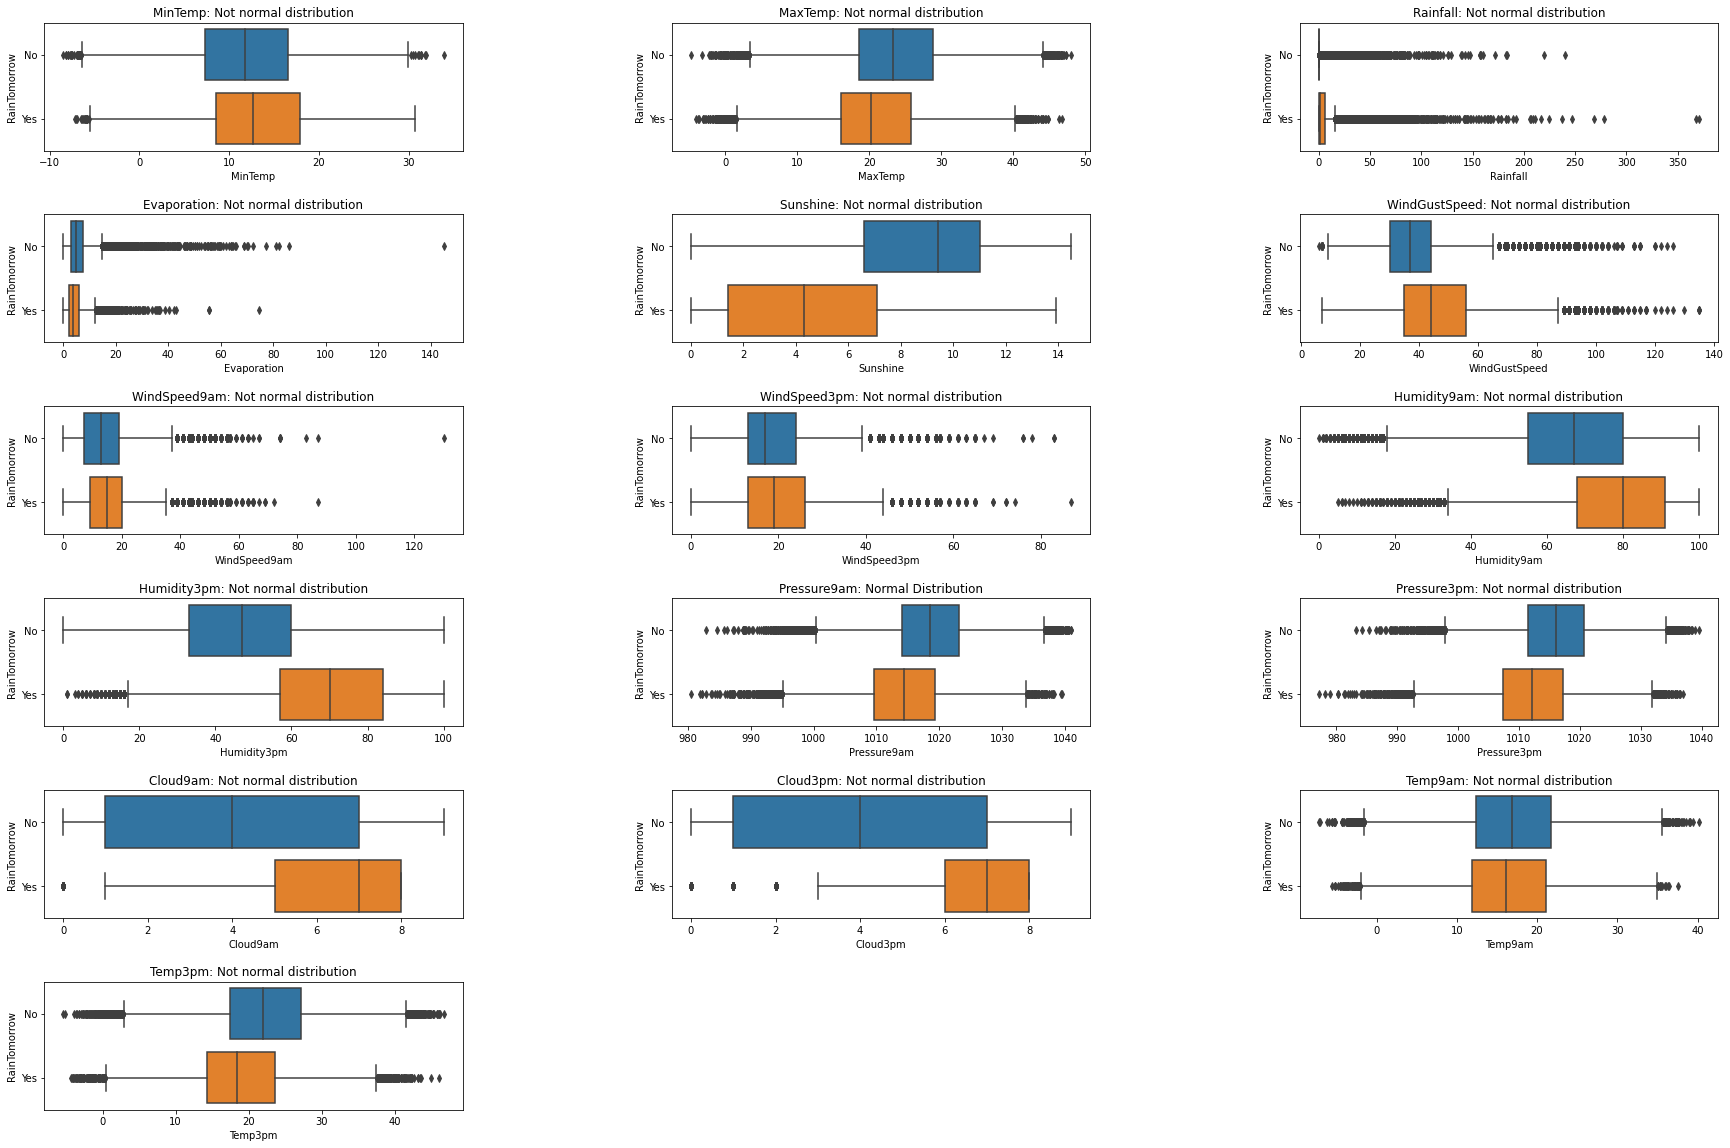

In [ ]:
plt.figure(figsize=(30,20))
for i, column in enumerate(df.drop([TARGET_NAME_CLS, TARGET_NAME_REG], axis=1).select_dtypes(exclude=[np.object]).columns, 1):
    plt.subplot(6,3, i)
    sns.boxplot(x=df[column], y=df[TARGET_NAME_CLS], data=df)
    dist = 'Normal Distribution' if shapiro(df[column].sample(3000).dropna())[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()
# sample was used to get random representation and not suffer from small amount of deviations
# Rainfall outliers? But in australia it may be dry weather almost all year and big amount of rainfall in some single days

ValueError: ignored

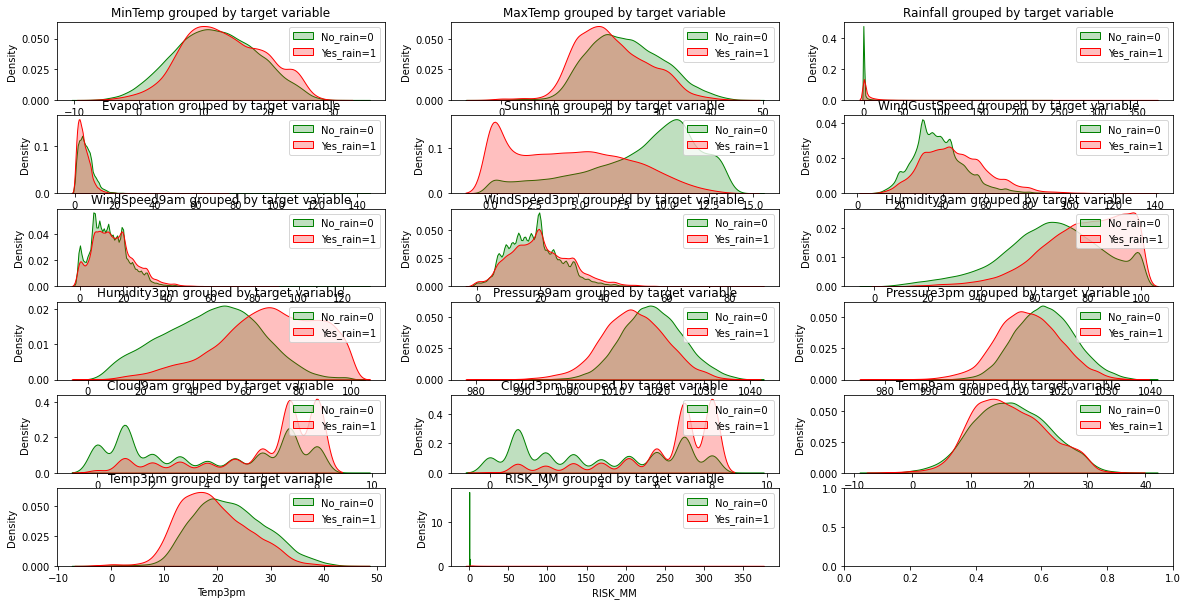

In [ ]:
plt.figure(figsize=(20, 10))
df[TARGET_NAME_CLS] = df[TARGET_NAME_CLS].map({'Yes': 1, 'No': 0})
numeric_cols = df.select_dtypes(exclude=np.object)
for idx, col in enumerate(numeric_cols, 1):
    plt.subplot(6, 3, idx)
    feature_with_target_s = df[[col, TARGET_NAME_CLS]]
    feature_s = feature_with_target_s[col]
    feature_target_0 = feature_s[feature_with_target_s[TARGET_NAME_CLS] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET_NAME_CLS] == 1]

    sns.kdeplot(feature_target_0, shade=True, label='No_rain=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label='Yes_rain=1', color='r')
    plt.xlabel(col)
    plt.title(f'{col} grouped by target variable')
    plt.legend(loc='best')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [5]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
"""
do not forget to use pipeline with sampler, scaler and estimator
to prevent data leakage - not applying sampling and same scaling params to every fold during validation
"""
def cross_validation(clf, X, y):
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=10, scoring='f1', n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
        print(f'Train GINI: {(2 * roc_train - 1):.3f}, Test GINI: {(2 * roc_test - 1):.3f}')
    print('Confusion Matrix', '\n', pd.crosstab(y_test, y_test_pred))

def custom_oversampling(df, target_name=TARGET_NAME_CLS, delimiter=0):
    target_counts = df[target_name].value_counts()
    major_class_name = target_counts.argmax()
    minor_clss_name = target_counts.argmin()
    disbalance_coef = int(target_counts[major_class_name] / target_counts[minor_clss_name]) - 1
    for i in range(disbalance_coef - delimiter):
        sample = df[df[target_name] == minor_clss_name].sample(target_counts[minor_clss_name])
        df = df.append(sample, ignore_index=True)
    return df.sample(frac=1)

def vote(predictions: list, weights: list):
    predictions = np.asarray(predictions).T
    maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
    return maj_vote

def reduce_memory(df):
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df
    
def evaluate_preds(true_values, pred_values, save=False):
    print("R2:\t" + str(round(r2_score(true_values, pred_values), 3)) + "\n" +
          "MAE:\t" + str(round(mae(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3)) + "\n" +
          "MSE_scaled:\t" + str(round(mse(true_values, pred_values) / np.median(true_values), 3)))
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=pred_values, y=true_values, alpha=0.6)
    plt.plot([0, 2e+7], [0, 2e+7], linestyle='--', color='red')
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    if save:
        if not os.path.exists('./saved'):
            os.makedirs('./saved')
        plt.savefig('./saved/' + 'report.png')
    plt.show()

In [6]:
location_mapping =  {'Adelaide': 0, 'Albany': 0, 'Albury': 0, 'AliceSprings': 1,
                    'BadgerysCreek': 0, 'Ballarat': 0, 'Bendigo': 0, 'Brisbane': 2,
                    'Cairns': 3, 'Canberra': 0, 'Cobar': 4, 'CoffsHarbour': 2,
                    'Dartmoor': 0, 'Darwin': 3, 'GoldCoast': 2, 'Hobart': 0, 'Katherine': 3,
                    'Launceston': 0, 'Melbourne': 0, 'MelbourneAirport': 0, 'Mildura': 4,
                    'Moree': 2, 'MountGambier': 0, 'MountGinini': 0, 'Newcastle': 0, 'Nhil': 4,
                    'NorahHead': 0, 'NorfolkIsland': 2, 'Nuriootpa': 0, 'PearceRAAF': 2,
                    'Penrith': 0, 'Perth': 2, 'PerthAirport': 2, 'Portland': 0, 'Richmond': 0,
                    'Sale': 0, 'SalmonGums': 4, 'Sydney': 0, 'SydneyAirport': 0, 'Townsville': 3,
                    'Tuggeranong': 0, 'Uluru': 1, 'WaggaWagga': 0, 'Walpole': 0, 'Watsonia': 0,'Williamtown': 0, 
                    'Witchcliffe': 0, 'Wollongong': 0, 'Woomera': 1}

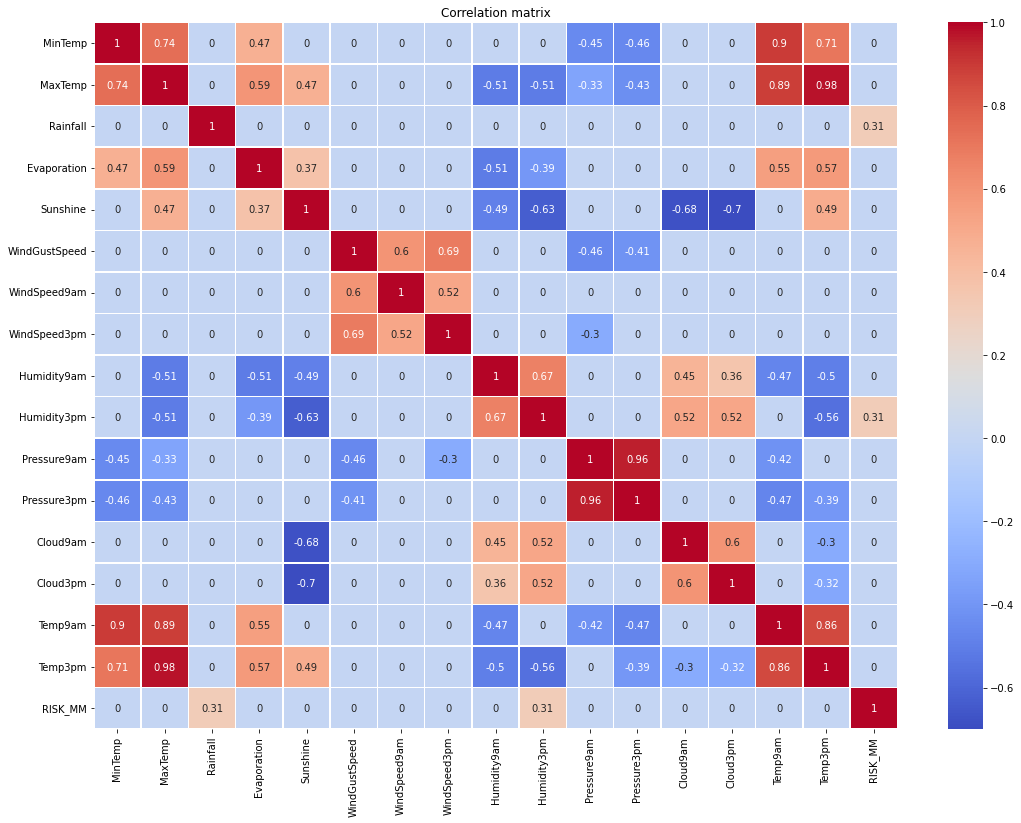

In [ ]:
plt.figure(figsize = (18,13))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [8]:
df = pd.read_csv(data_root)
df = reduce_memory(df)

Memory usage of dataframe is 26.04 MB
Memory usage after optimization is: 10.46 MB
Decreased by 59.8%


In [ ]:
from sklearn.feature_selection import VarianceThreshold
v_thresh = VarianceThreshold(threshold=15.)
X_sup = v_thresh.fit_transform(X)
mask = v_thresh.get_support()

In [ ]:
[x for i, x in enumerate(df.columns) if mask[i]]

In [ ]:
"""
def generate_time_lags(df, column, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n[column].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n
#df_ = generate_time_lags(df, 'Evaporation', 3)
#df_ = reduce_memory(df_)

In [ ]:
base = make_pipeline(StandardScaler(), LinearRegression())
base.fit(X_train, y_train)
pred_train = base.predict(X_train)
pred_test = base.predict(X_test)
r2_score(y_train, pred_train), r2_score(y_test, pred_test)

In [ ]:
mean_absolute_error(y_train, pred_train), mean_absolute_error(y_test, pred_test)

(24.550332733197546, 24.519905194418186)

In [ ]:
base_cls = make_pipeline(StandardScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                         max_iter=200, class_weight='balanced'))
base_cls.fit(X_train, y_train_cls)
pred_cls_train = base_cls.predict(X_train)
pred_cls_test = base_cls.predict(X_test)
report(y_train_cls, pred_cls_train, y_test_cls, pred_cls_test)

Train
               precision    recall  f1-score   support

           0      0.913     0.850     0.881     74526
           1      0.680     0.798     0.735     29810

    accuracy                          0.835    104336
   macro avg      0.797     0.824     0.808    104336
weighted avg      0.847     0.835     0.839    104336

Test
               precision    recall  f1-score   support

           0      0.917     0.848     0.881     33139
           1      0.581     0.733     0.648      9519

    accuracy                          0.823     42658
   macro avg      0.749     0.791     0.765     42658
weighted avg      0.842     0.823     0.829     42658

Train ROC_AUC: 0.824, Test ROC_AUC: 0.791
Train GINI: 0.649, Test GINI: 0.581
Confusion Matrix 
 col_0      0     1
row_0             
0      28111  5028
1       2543  6976


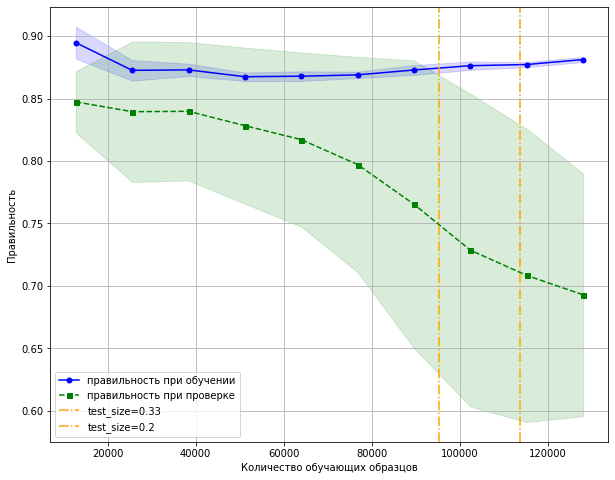

In [ ]:
estimator = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=1, solver='lbfgs', penalty='l2', C=1000.0, tol=1e-4, 
                          max_iter=200, class_weight='balanced'))
train_sizes, train_scores, test_scores = learning_curve(estimator=estimator, X=X, y=y_cls, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), cv=10, scoring='roc_auc', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.67, color='orange', linestyle='-.', label='test_size=0.33')
plt.axvline(X.shape[0]*0.8, color='orange', linestyle='-.', label='test_size=0.2')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# оптимальный test_size=0.2

In [ ]:
#X, y = df.drop([TARGET_NAME_CLS, TARGET_NAME_REG], axis=1), df[TARGET_NAME_CLS]
X, y = train.drop([TARGET_NAME_CLS], axis=1), train[TARGET_NAME_CLS]
#y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, stratify=y, random_state=1)

feature_names = list(X_train.columns)
cat_features = X.select_dtypes(include='category').columns.to_list()
cat_indices = [i for i, col in enumerate(X.columns) if col in cat_features]

under = RandomUnderSampler(sampling_strategy=0.3, random_state=1)
smnc = SMOTENC(sampling_strategy=0.37, categorical_features=cat_indices, random_state=1, n_jobs=-1)
X_train, y_train = under.fit_resample(X_train, y_train)
X_train, y_train = smnc.fit_resample(X_train, y_train)

train_pool = Pool(X_train, y_train, feature_names=feature_names, cat_features=cat_features)
test_pool = Pool(X_test, y_test, feature_names=feature_names, cat_features=cat_features)

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(iterations=200, random_seed=0)
    summary = model.select_features(
        train_pool,
        eval_set=test_pool,
        features_for_select=list(range(train_pool.num_col())),
        num_features_to_select=int(X_train.shape[1]*0.9),
        steps=steps,
        algorithm=algorithm,
        shap_calc_type=EShapCalcType.Regular,
        train_final_model=False,
        logging_level='Silent',
        plot=False
    )
    print('Selected features:', summary['selected_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=3)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


The number of features selection steps (3) is greater than the number of features to eliminate (2). The number of steps was reduced to 2.


Selected features: ['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'REG_TARGET']


In [ ]:
feature_set['eliminated_features_names'], feature_set['selected_features_names'] # second is for final dataset

(['Date', 'WindSpeed9am'],
 ['Location',
  'MinTemp',
  'MaxTemp',
  'Rainfall',
  'WindGustDir',
  'WindGustSpeed',
  'WindDir9am',
  'WindDir3pm',
  'WindSpeed3pm',
  'Humidity9am',
  'Humidity3pm',
  'Pressure9am',
  'Pressure3pm',
  'Temp9am',
  'Temp3pm',
  'RainToday',
  'REG_TARGET'])

In [ ]:
x = np.random.normal(100, 5, size=500).reshape(-1,1)
for i in range(500):
    if i % 2 == 0:
        x[i] = np.nan
imp = IterativeImputer(random_state=1)
imp.fit(x)
y = np.random.normal(100, 6, size=500).reshape(-1,1)
print(y[0,:])
for i in range(500):
    if i % 2 == 0:
        y[i] = np.nan
print(y[0,:])
imp.transform(x)[0,:]

[109.1356847]
[nan]


array([99.67134667])

In [7]:
class Preprocessor:
    def __init__(self, target=TARGET_NAME_CLS, r_target=TARGET_NAME_REG):
        self.target = target
        self.train = True
        self.imputers = []
        self.reg_target = r_target
        self.sub_df = None
        self.rain = {}
        self.no_rain = {}
        self.cat = None
        self.temp = None
        self.medians = None
        self.modes = None
        self.power = PowerTransformer(method='box-cox')
        #self.scaler = MinMaxScaler()
        #self.kmeans = KMeans(n_clusters=2, init='k-means++', n_init=5, max_iter=30, random_state=1, tol=1e-2)

    def __call__(self, df, create=False):
        self.train = True if self.target in df.columns else False
        df = self.reduce_memory(df)
        if self.train:
            df = self.fit(df)
        df = self.transform(df)
        if create:
            df = self.create_features(df)
        if self.train:
            #df[self.target] = LabelEncoder().fit_transform(df[self.target])
            df[self.target] = df[self.target].map({'Yes': 1, 'No': 0})
        df = self.reduce_memory(df)
        #df = df.sample(frac=1)
        return df
    
    def fit(self, df):
        self.medians = df.median()
        self.modes = df.mode()
        #numeric_cols = df.drop([self.reg_target,'Date', 'Evaporation', 
        #                        'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1).select_dtypes(exclude='category').columns
        #to_fit = self.scaler.fit_transform(df[numeric_cols].dropna())
        #self.kmeans.fit(to_fit)
        return df

    def transform(self, df):
        df.Date = pd.to_datetime(df.Date)
        #df.Location = df.Location.map(location_mapping)

        #self.index = df.sort_values(by=['Location', 'Date']).index

        df.Date = df.Date.dt.month.astype('category') #.apply(lambda x: x%12 // 3 + 1).astype('category')
        df.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'], axis=1, inplace=True)

        numeric_cols = df.drop([self.reg_target,'Date'], axis=1).select_dtypes(exclude='category').columns       

        if self.train:
            self.temp = df.dropna().groupby(['RainToday', 'Date', 'Location']).agg({self.reg_target: 'median'}).reset_index()
            self.temp = self.temp.rename(columns={self.reg_target: 'temp_var'})
            cat_cols = df.drop(self.target, axis=1).select_dtypes(include='category').columns.to_list()
            # transformed y to better split answers: accuracy improved, f1 from 0.656 to 0.655
            X, y = df.dropna().drop([self.target, self.reg_target], axis=1), np.log(df.dropna()[self.reg_target] + 1e-6)
            X = X.merge(self.temp, on=['RainToday', 'Date', 'Location'], how='left')
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=1)
            train_pool = Pool(X_train, y_train+1e-3, cat_features=cat_cols)
            test_pool = Pool(X_test, y_test+1e-3, cat_features=cat_cols)
            params_model = {
                            'eval_metric': 'R2',
                            'silent': True,
                            'one_hot_max_size': 49,
                            'early_stopping_rounds': 5,
                            'boosting_type': 'Ordered',
                            'allow_writing_files': False,
                            'use_best_model': True,
                            'random_seed': 1
                            }
            self.cat = CatBoostRegressor(**params_model)
            self.cat.fit(train_pool, eval_set=test_pool)
            """
            plt.figure(figsize=(6,6))
            sns.scatterplot(x=self.cat.predict(X_test), y=y_test, alpha=0.6)
            plt.plot([-15, 22], [-15, 22], linestyle='--', color='red')
            plt.xlabel('Predicted values')
            plt.ylabel('True values')
            plt.title('True vs Predicted values')
            plt.show()
            """
            print(f'Score R2 {self.reg_target}: {self.cat.get_best_score()}')

        """
        print('Detecting outlieurs...')
        X = df.select_dtypes(exclude=['category']).drop(self.reg_target, axis=1).fillna(df.median())
        iso = eif.iForest(X.values.astype(np.double), ntrees=200, sample_size=256, ExtensionLevel=X.shape[1]-1)
        anomaly_scores = iso.compute_paths(X_in = X.values.astype(np.double))
        X['outliers'] = -anomaly_scores
        q = X['outliers'].quantile(q=0.05)
        X['outliers'] =  X['outliers'].apply(lambda x: 0 if x<=q else 1)
        X['outliers'].value_counts()
        XX = X[X.outliers == 0].drop('outliers', axis=1)
        df['isSusp'] = 0
        df.loc[XX.index, 'isSusp'] = 1
        del X
        del XX
        print(f'{df[df.isSusp == 1].shape[0]} outliers found.')

        df['isNA'] = 0
        df[df.isna()]['isNa'] = 1
        """
        # also need to split on train/test
        q3, q1 = np.quantile(df.WindSpeed9am, q=0.75), np.quantile(df.WindSpeed9am, q=0.25)
        df.loc[df['WindSpeed9am'] > 100, 'WindSpeed9am'] = q3 + 1.5 * (q3 - q1)

        df.RainToday.fillna(self.modes['RainToday'][0], inplace=True)
        print(f'Numeric rows containg nans: {df.select_dtypes(exclude="category").isnull().any(axis=1).sum()} / {df.shape[0]}')
        # numeric_cols = df.drop([self.reg_target,'Date'], axis=1).select_dtypes(exclude='category').columns
        
        """ if just dropping all nans
        if self.target not in df.columns:
            df = pd.concat([df, test_target], axis=1)
            df.dropna(inplace=True)
            self.out = df[self.target]
            df.drop(self.target, axis=1, inplace=True)
        df.dropna(inplace=True)
        """

        if self.train:
            agg_dict = {col: 'median' for col in numeric_cols}
            self.rain = df[df.RainToday == 'Yes'].groupby('Location').agg(agg_dict)
            self.no_rain = df[df.RainToday == 'No'].groupby('Location').agg(agg_dict)
            rain = IterativeImputer(random_state=1).fit_transform(self.rain)
            no_rain = IterativeImputer(random_state=1).fit_transform(self.no_rain)
            self.rain.iloc[:,:] = rain
            self.no_rain.iloc[:,:] = no_rain
            self.rain = self.rain.to_dict()
            self.no_rain = self.no_rain.to_dict()

        for col in numeric_cols:
            for location in df.Location.unique():
                condition = ((df.Location == location) & (df[col].isna()))
                df.loc[(condition & (df.RainToday == 'Yes')), col] = self.rain.get(col).get(location)
                df.loc[(condition & (df.RainToday == 'No')), col] = self.no_rain.get(col).get(location)

                #df.loc[((df[col].isna()) & (df.RainToday == 'Yes')), col] = df.loc[df.RainToday == 'Yes', col].mean()
                #df.loc[((df[col].isna()) & (df.RainToday == 'No')), col] = df.loc[df.RainToday == 'No', col].mean()
        print(f'Numeric rows containg nans after mean imputation: {df.select_dtypes(exclude="category").isnull().any(axis=1).sum()} / {df.shape[0]}')
        
        """ Too many nans
        print('Fitting imputers')
        if self.train:
            for locat in df.Location.unique():
                for label in ['Yes', 'No']:
                    condition = ((df.Location == locat) & (df.RainToday == label))
                    try:
                        imputer = IterativeImputer(random_state=1)
                        imputer.fit(df.loc[condition, numeric_cols])
                        self.imputers.append(imputer)
                    except ValueError as exc:
                        self.imputers.append(None)
                        pass
        print('Transforming imputations')
        for i, locat in enumerate(df.Location.unique()):
            for label in ['Yes', 'No']:
                condition = ((df.Location == locat) & (df.RainToday == label))
                try:
                    if self.imputers[i] is not None:
                        imputer = self.imputers[i]
                        df.loc[condition, numeric_cols] = imputer.transform(df.loc[condition, numeric_cols])
                except ValueError as exc:
                    pass
        """
        # if df.isnull().any(axis=1).sum() / df.shape[0] > 0.05 or df.shape <= 1000:

        for col in numeric_cols:
            for locat in df.Location.unique():
                for label in ['Yes', 'No']:
                    condition = ((df.Location == locat) & (df.RainToday == label))
                    df.loc[condition, col] = df.loc[condition, col].interpolate(method='from_derivatives')
        print(f'Nans left: {df.isna().sum().sum()}')
        df.fillna(method='ffill', inplace=True)

        self.reg_target_values = df[self.reg_target].copy()
        df.drop(self.reg_target, axis=1, inplace=True)
        """
        q3, q1 = np.quantile(df.Evaporation, q=0.75), np.quantile(df.Evaporation, q=0.25)
        df.loc[df['Evaporation'] > 100, 'Evaporation'] = q3 + 1.5 * (q3 - q1)
        q3, q1 = np.quantile(df.Cloud9am, q=0.75), np.quantile(df.Cloud9am, q=0.25)
        df.loc[df['Cloud9am'] <= 1, 'Cloud9am'] = q3 - 1.5 * (q3 - q1)
        q3, q1 = np.quantile(df.Cloud3pm, q=0.75), np.quantile(df.Cloud3pm, q=0.25)
        df.loc[df['Cloud3pm'] <= 2, 'Cloud3pm'] = q3 - 1.5 * (q3 - q1)
        """
        
        print(f'filling nans in categories: {df.select_dtypes(include="category").isnull().any(axis=1).sum()} / {df.shape[0]}')
        cat_cols = df.select_dtypes(include='category').columns[2:-1] 
        df['RainToday'].fillna('No', inplace=True)
        for column in cat_cols:
            if column not in ['Date', 'Location', self.target]:
                df[column].fillna(self.modes[column][0], inplace=True)
            #    df[column] = df[column].astype(np.object)
            #    df.loc[df[column].isna(), column] = 'UNK'
            #    df[column] = df[column].astype('category')

        # df['cluster'] = self.kmeans.predict(self.scaler.transform(df[numeric_cols]))
        # df['cluster'] = df['cluster'].astype('category') 
        
        df = df.merge(self.temp, on=['RainToday', 'Date', 'Location'], how='left')
        df['temp_var'].fillna(method='ffill', inplace=True)
        if self.train:
          # !!!! 10** logx = 10**?
            df['REG_TARGET'] = 10 ** self.cat.predict(df.drop([self.target], axis=1))
            df['REG_TARGET'] = np.where(df['REG_TARGET'] < 0, 0.1, df['REG_TARGET'])
            df['REG_TARGET'] = self.power.fit_transform(df['REG_TARGET'].values.reshape(-1,1))
            df['REG_TARGET'] = np.where(df['REG_TARGET'] > 1.12505, 1, 0)
            df['REG_TARGET'] = df['REG_TARGET'].astype('category')
        else:
            df['REG_TARGET'] = 10 ** self.cat.predict(df)
            df['REG_TARGET'] = np.where(df['REG_TARGET'] < 0, 0.1, df['REG_TARGET'])
            df['REG_TARGET'] = self.power.transform(df['REG_TARGET'].values.reshape(-1,1))
            df['REG_TARGET'] = np.where(df['REG_TARGET'] > 1.12505, 1, 0)
            df['REG_TARGET'] = df['REG_TARGET'].astype('category')
            
        df.drop('temp_var', axis=1, inplace=True)

        return df
    
    def create_features(self, df):
        print(f'Nans left: {df.isna().sum().sum()}')
        # makes no actual sense as we shuffled dataset in train_test split, the df is sorted but days may have holes
        # to avoid this we can map locations into 3 category and not shuffle train-test
        df.sort_index(inplace=True)
        df['Temp_diff'] = df['MaxTemp'].diff()
        df['Temp_diff'].fillna(method='bfill', inplace=True)

        # lags features not improving
        weights = np.linspace(0.1, 1, 3)
        df['3pmHum_r'], df['9amHum_r'] = 0, 0
        for location in df.Location.unique():
            condition = (df.Location == location)
            df.loc[condition, '3pmHum_r'] = df.loc[condition, 'Humidity3pm'].rolling(3).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True)
            df.loc[condition, '9amHum_r'] = df.loc[condition, 'Humidity9am'].rolling(3).apply(lambda close: np.dot(close, weights)/weights.sum(), raw=True)
        df['3pmHum_r'].fillna(method='bfill', inplace=True)
        df['9amHum_r'].fillna(method='bfill', inplace=True)

        #if self.train:
        #    self.sub_df = df.groupby(by=['Date', 'Location']).agg({'Sunshine': 'mean'}).reset_index()
        #    self.sub_df = self.sub_df.rename(columns={'Sunshine': 'Sunshine_mean'})
        #df = df.merge(self.sub_df, on=['Date', 'Location'], how='left')

        return df
    
    @staticmethod
    def reduce_memory(df):
        return reduce_memory(df)
    
    @staticmethod
    def resample(X, y, strategy=[.3, .4]):
        under = RandomUnderSampler(sampling_strategy=strategy[0], random_state=1)
        smote = SMOTE(sampling_strategy=strategy[1], random_state=1)
        X, y = under.fit_resample(X, y)
        X, y = smote.fit_resample(X, y)
        return X, y

In [ ]:
(train.REG_TARGET == train[TARGET_NAME_CLS]).astype(int).sum()

109085

OPTUNA+BORUTA+CATBOOST

In [ ]:
df = pd.read_csv(data_root)
df_feat, df_target = df.drop(TARGET_NAME_CLS, axis=1), df[TARGET_NAME_CLS]
train, test, train_target, test_target = train_test_split(df_feat, df_target, test_size=0.1, shuffle=True,
                                                          stratify=df_target, random_state=42)
train = pd.concat([train, train_target], axis=1)
preprocessor = Preprocessor()
train = preprocessor(train)
test = preprocessor(test)
test_target = test_target.map({'Yes': 1, 'No': 0})

In [17]:
enc_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
binary_cols = ['RainToday',]

In [9]:
X, y = train.drop(TARGET_NAME_CLS, axis=1), train[TARGET_NAME_CLS]
for col in X.columns:
    if X[col].dtype == 'category':
        X[col] = X[col].astype('object')
y = y.astype(np.uint8)
X.head(1)

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,REG_TARGET
0,6,Dartmoor,4.7,26.200001,0.0,ESE,37.0,E,NE,6.0,7.0,68.0,28.0,1019.700012,1014.299988,15.1,23.700001,No,0


In [31]:
col_trans = ColumnTransformer(transformers=[
                                            ('binary', ce.binary.BinaryEncoder(), binary_cols),
                                            ('enc', ce.cat_boost.CatBoostEncoder(random_state=123, a=5), enc_cols),
                                           ], remainder='passthrough')
X_ = col_trans.fit_transform(X, y)


For advanced search
```
!pip install -qU BorutaShap

from BorutaShap import BorutaShap

selector = BorutaShap(imporatance_measure='shap', classification=True)
# sample = True to speed up training - samples dataset (statistics)
selector.fit(X_train, y_train, n_trials=100, sample=True, verbose=False)
# take weak feature names
features_to_remove = selector.features_to_remove
```
The default model is the Random Forest. However other tree based models can be used instead, such as DecisionTreeClassifier, RandomForestClassifier, XGBClassifier and CatBoostClassifier


In [20]:
from BorutaShap import BorutaShap
from lightgbm import LGBMClassifier

In [32]:
# if using default RandomForestClassifier, wich is slow, especially for large datasets!
X_columns = ['RainToday_0', 'RainToday_1', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 
             'Date', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
             'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm', 'REG_TARGET']
X_ = pd.DataFrame(data=X_, index=X.index, columns=X_columns, dtype=np.float32)

In [34]:
model = LGBMClassifier(verbose=0)

In [35]:
selector = BorutaShap(model=model, importance_measure='shap', classification=True)
selector.fit(X_, y, n_trials=20, sample=True, verbose=False)

  0%|          | 0/20 [00:00<?, ?it/s]

In [36]:
selector.features_to_remove

array(['RainToday_0', 'RainToday_1'], dtype=object)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# define Boruta Feature Selector that combines math statistical tests with clf feature importances
# btw, sklearn rf is extremely slow with large dataset, as alt. we may use lgbm 'rf' mode
clf = RandomForestClassifier(n_estimators=25, max_depth=3, class_weight='balanced', random_state=123)
selector = BorutaPy(clf, n_estimators='auto', random_state=123, max_iter=10)
select = selector.fit_transform(X_, y)

In [ ]:
# all columns are relevant
selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [37]:
# we will not use sampling as if boosting models may suffer from high variance and samplers add variance more
X, y = train.drop([TARGET_NAME_CLS], axis=1), train[TARGET_NAME_CLS]
X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.25, shuffle=True, stratify=y, random_state=123)

cat_cols = X_train.select_dtypes(include=['category']).columns.tolist()

train_pool = Pool(X_train, y_train, cat_features=cat_cols)
valid_pool = Pool(X_valid, y_valid, cat_features=cat_cols)

In [38]:
params_model = {
    'eval_metric': 'AUC', 
    'iterations': 1000,
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 15,
    'early_stopping_rounds': 10,
    'grow_policy': 'SymmetricTree',
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 123,
    'max_ctr_complexity': 8,
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'],
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], 
    }

In [39]:
def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 9),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1., 5.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 3.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),
                    }
    param_trials.update(params_model)
    opt_model = CatBoostClassifier(**param_trials)
    opt_model.fit(train_pool, eval_set=valid_pool)
    
    y_pred = opt_model.predict_proba(X_valid)[:,1]
    score = roc_auc_score(y_valid, y_pred)
    
    return score  # cross_val_score(...).mean()

In [ ]:
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=100, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

In [ ]:
X_train.describe(include=['category'])

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,REG_TARGET
count,95979,95979,95979,95979,95979,95979,95979
unique,12,49,16,16,16,2,2
top,5,Canberra,W,N,SE,No,0
freq,8594,2294,7024,8223,7372,74636,78347


In [ ]:
# parameters without boruta removals
params_model = {
                'eval_metric': 'AUC', 
                'iterations': 1000,
                'auto_class_weights': 'Balanced',
                'silent': True,
                'one_hot_max_size': 16,
                'early_stopping_rounds': 5, # 10
                'grow_policy': 'SymmetricTree',
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
                'max_ctr_complexity': 8,
                'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'],
                'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], 
                'depth': 7, # 9
                'learning_rate': 0.041073861509768717, 
                'l2_leaf_reg': 5.404577297507364, # 4.404577297507364
                'bagging_temperature': 2.466430192930787, 
                'subsample': 0.8115177713818562, 
                'colsample_bylevel': 0.5669081969033037, 
                'boosting_type': 'Ordered' # Plain
                }

In [ ]:
cat = CatBoostClassifier(**params_model)
cat.fit(train_pool, eval_set=valid_pool)

# better StratifiedKFold with 3..4 splits
cat_train_pred = cat.predict(X_train)
cat_test_pred = cat.predict(X_valid)
cat_train_proba = cat.predict_proba(X_train)[:,1]
cat_test_proba = cat.predict_proba(X_valid)[:,1]

report(y_train, cat_train_pred, y_valid, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.922     0.857     0.888     74462
           1      0.601     0.748     0.667     21517

    accuracy                          0.832     95979
   macro avg      0.762     0.802     0.777     95979
weighted avg      0.850     0.832     0.838     95979

Test
               precision    recall  f1-score   support

           0      0.916     0.852     0.883     24822
           1      0.587     0.729     0.650      7172

    accuracy                          0.824     31994
   macro avg      0.752     0.790     0.767     31994
weighted avg      0.842     0.824     0.831     31994

Train ROC_AUC: 0.890, Test ROC_AUC: 0.880
Train GINI: 0.780, Test GINI: 0.761
Confusion Matrix 
 col_0             0     1
RainTomorrow             
0             21153  3669
1              1947  5225


In [49]:
# parameters with borutaShap feature selection 
params_model = {
                'eval_metric': 'AUC', 
                'iterations': 1000,
                'auto_class_weights': 'Balanced',
                'silent': True,
                'one_hot_max_size': 16,
                'early_stopping_rounds': 5,
                'grow_policy': 'SymmetricTree',
                'allow_writing_files': False,
                'use_best_model': True,
                'random_seed': 123,
                'max_ctr_complexity': 8,
                'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'],
                'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], 
                'depth': 8,
                'learning_rate': 0.041466421329671835, 
                'l2_leaf_reg': 4.9005201832815946, 
                'bagging_temperature': 2.307128909554922, 
                'subsample': 0.47296354316762107, 
                'colsample_bylevel': 0.5873139756747939, # 0.6873139756747939
                'boosting_type': 'Plain' # optuna results + Ordered = no overfitting with auc=0.865 
                }

In [50]:
cat = CatBoostClassifier(**params_model)
cat.fit(train_pool, eval_set=valid_pool)

cat_train_pred = cat.predict(X_train)
cat_test_pred = cat.predict(X_valid)
cat_train_proba = cat.predict_proba(X_train)[:,1]
cat_test_proba = cat.predict_proba(X_valid)[:,1]

report(y_train, cat_train_pred, y_valid, cat_test_pred, cat_train_proba, cat_test_proba)

Train
               precision    recall  f1-score   support

           0      0.940     0.861     0.899     74462
           1      0.628     0.811     0.708     21517

    accuracy                          0.850     95979
   macro avg      0.784     0.836     0.804     95979
weighted avg      0.870     0.850     0.856     95979

Test
               precision    recall  f1-score   support

           0      0.921     0.848     0.883     24822
           1      0.587     0.747     0.657      7172

    accuracy                          0.826     31994
   macro avg      0.754     0.797     0.770     31994
weighted avg      0.846     0.826     0.832     31994

Train ROC_AUC: 0.917, Test ROC_AUC: 0.888
Train GINI: 0.835, Test GINI: 0.775
Confusion Matrix 
 col_0             0     1
RainTomorrow             
0             21060  3762
1              1818  5354


In [ ]:
# DROPPING ALL NANS ANS USE RAW DATA
df = pd.read_csv(data_root)
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=1)
train.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM', 'Date'], axis=1, inplace=True)
train.dropna(inplace=True)
test.drop(['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm', 'RISK_MM', 'Date'], axis=1, inplace=True)
test.dropna(inplace=True)
test, y_cls_labels = test.drop(TARGET_NAME_CLS, axis=1), test[TARGET_NAME_CLS]
enc = LabelEncoder()
train[TARGET_NAME_CLS] = enc.fit_transform(train[TARGET_NAME_CLS])
y_cls_labels = enc.transform(y_cls_labels) 
train = reduce_memory(train)
test = reduce_memory(test)

Memory usage of dataframe is 14.73 MB
Memory usage after optimization is: 6.01 MB
Decreased by 59.2%
Memory usage of dataframe is 1.55 MB
Memory usage after optimization is: 0.66 MB
Decreased by 57.4%


In [ ]:
# raw
df = pd.read_csv(data_root)
df = reduce_memory(df)
df = df.drop(['Date', TARGET_NAME_REG], axis=1)
df[TARGET_NAME_CLS] = LabelEncoder().fit_transform(df[TARGET_NAME_CLS])
train, test = train_test_split(df, test_size=0.1, shuffle=True, random_state=1)
test, y_cls_labels = test.drop([TARGET_NAME_CLS], axis=1), test[TARGET_NAME_CLS]
X, y = train.drop(TARGET_NAME_CLS, axis=1), train[TARGET_NAME_CLS]
X = X.fillna(method='ffill')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)
cat_cols = train.select_dtypes(include='category').columns.to_list()

Memory usage of dataframe is 26.04 MB
Memory usage after optimization is: 10.49 MB
Decreased by 59.7%


In [ ]:
# Catboost

In [ ]:
# look for one_hot_max_size
max_size = 0
for column in train.select_dtypes(include='category').columns:
    size = df[column].nunique()
    print(f'{column}: {size} categories')
    if size > max_size:
        max_size = size
print(max_size)

Location: 49 categories
WindGustDir: 16 categories
WindDir3pm: 16 categories
RainToday: 2 categories
49


In [ ]:
train.drop(['Date', 'WindSpeed9am'], axis=1, inplace=True)  # as from feature selection
test.drop(['Date', 'WindSpeed9am'], axis=1, inplace=True)
cat_cols = train.select_dtypes(include='category').drop(TARGET_NAME_CLS, axis=1).columns.to_list()
cat_indices = [i for i, x in enumerate(train.drop(TARGET_NAME_CLS, axis=1).columns) if x in cat_cols]
under = RandomUnderSampler(sampling_strategy=0.4, random_state=1)
smote = SMOTENC(sampling_strategy=0.45, categorical_features=cat_indices, random_state=1)

In [ ]:
X, y = train.drop([TARGET_NAME_CLS], axis=1), train[TARGET_NAME_CLS]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y, random_state=1)

In [ ]:
feature_weights = ','.join([f'{col}:2' if col in ['Humidity3pm', 'Pressure3pm'] else f'{col}:1' for col in X_train.columns.to_list()])
feature_weights

'Location:1,MinTemp:1,MaxTemp:1,Rainfall:1,WindGustDir:1,WindGustSpeed:1,WindDir9am:1,WindDir3pm:1,WindSpeed3pm:1,Humidity9am:1,Humidity3pm:2,Pressure9am:1,Pressure3pm:2,Temp9am:1,Temp3pm:1,RainToday:1,REG_TARGET:1'

In [ ]:
X_train, y_train = under.fit_resample(X_train, y_train)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
np.bincount(y_train)[0] / np.bincount(y_train)[1]

2.222310405643739

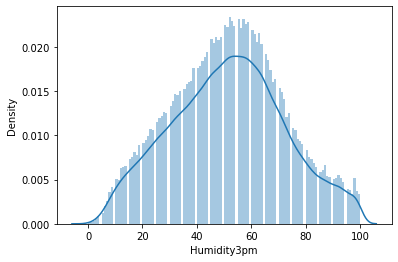

In [ ]:
sns.distplot(X.Humidity3pm, bins=120)
plt.show()

In [ ]:
train_pool = Pool(X_train, y_train, cat_features=cat_cols)
test_pool = Pool(X_test, y_test, cat_features=cat_cols) 
params_model = {
    'eval_metric': 'Logloss', # AUC, F1
    'auto_class_weights': 'Balanced',
    'silent': True,
    'one_hot_max_size': 16,
    'early_stopping_rounds': 5,
    'boosting_type': 'Plain', # Ordered - good for small datasets
    'grow_policy': 'SymmetricTree', # 'Depthwise',
    'allow_writing_files': False,
    'use_best_model': True,
    'random_seed': 1,
    'max_ctr_complexity': 6,
    'combinations_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'], # to increase border between encoded categories
    'simple_ctr': ['Counter:CtrBorderCount=40:Prior=0.5/1'],
    
}

In [ ]:
catboost = CatBoostClassifier(**params_model) #, use_best_model=False)

params_grid = {
    'depth': [4, 5, 6, 7],
    'learning_rate': [0.03, 0.1, 0.3, 0.5],
    'iterations': [200, 400],
    'l2_leaf_reg': [2, 2.5, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2],
    'subsample': [None, 0.3, 0.5, 0.7, 0.9],
}
gs = catboost.randomized_search(params_grid, train_pool, n_iter=30, shuffle=True, stratified=True, 
                                 partition_random_seed=1, cv=5)

In [ ]:
gs['params']

{'bagging_temperature': 1.5,
 'depth': 5,
 'iterations': 200,
 'l2_leaf_reg': 4,
 'learning_rate': 0.3,
 'subsample': 0.7}

In [ ]:
init_catboost = CatBoostClassifier(verbose=False)
init_catboost.fit(train_pool, eval_set=test_pool)
params = init_catboost.get_all_params()

In [ ]:
params = catboost.get_all_params()  # best params from blackbox

In [ ]:
catboost = CatBoostClassifier(**params_model, bagging_temperature=1.5, depth=5, learning_rate=0.3, 
                              feature_weights=feature_weights, iterations=200, l2_leaf_reg=4., subsample=0.7)
# better without feature weights, more stable
catboost.fit(train_pool, eval_set=test_pool) 
pred_train = catboost.predict(X_train)
pred_test = catboost.predict(X_test)
report(y_train, pred_train, y_test, pred_test)

Train
               precision    recall  f1-score   support

           0      0.898     0.844     0.870     50205
           1      0.694     0.786     0.737     22592

    accuracy                          0.826     72797
   macro avg      0.796     0.815     0.804     72797
weighted avg      0.835     0.826     0.829     72797

Test
               precision    recall  f1-score   support

           0      0.919     0.837     0.876     29785
           1      0.569     0.744     0.645      8607

    accuracy                          0.816     38392
   macro avg      0.744     0.791     0.761     38392
weighted avg      0.841     0.816     0.824     38392

Train ROC_AUC: 0.815, Test ROC_AUC: 0.791
Train GINI: 0.631, Test GINI: 0.581
Confusion Matrix 
 col_0             0     1
RainTomorrow             
0             24943  4842
1              2203  6404


In [ ]:
# fit further on test data - partial fit, learning rate decay
catboost_next = CatBoostClassifier(**params_model, bagging_temperature=2., depth=5, learning_rate=0.1,
                              iterations=200, l2_leaf_reg=5., subsample=0.8)
catboost_next.fit(test_pool, eval_set=Pool(test, test_target, cat_features=cat_cols), init_model=catboost) # partial fit using lr decay
pred_test_next = catboost_next.predict(X_test)
pred_test_final = catboost_next.predict(test)
report(y_test, pred_test_next, test_target, pred_test_final)

Train
               precision    recall  f1-score   support

           0      0.927     0.806     0.862     29785
           1      0.538     0.780     0.637      8607

    accuracy                          0.800     38392
   macro avg      0.732     0.793     0.749     38392
weighted avg      0.840     0.800     0.812     38392

Test
               precision    recall  f1-score   support

           0      0.926     0.806     0.862     11032
           1      0.536     0.778     0.635      3188

    accuracy                          0.800     14220
   macro avg      0.731     0.792     0.748     14220
weighted avg      0.839     0.800     0.811     14220

Train ROC_AUC: 0.793, Test ROC_AUC: 0.792
Train GINI: 0.586, Test GINI: 0.583
Confusion Matrix 
 col_0            0     1
RainTomorrow            
0             8890  2142
1              709  2479


In [ ]:
importancies = catboost.feature_importances_
indices = np.argsort(importancies)[::-1]
imp_cols = X.columns.values[indices]
for col, imp in zip(imp_cols, importancies[indices]):
    print(f'{col}: {imp}')

Humidity3pm: 20.590394040337376
WindGustSpeed: 10.902996199683997
Pressure3pm: 8.76116445618998
WindSpeed3pm: 8.336084630684436
Pressure9am: 6.961584951272208
Location: 6.304417070768342
MinTemp: 5.2778566076326054
REG_TARGET: 4.488663145115821
WindDir3pm: 4.405710087374223
Temp3pm: 3.51944255424311
Rainfall: 3.5052950246606938
MaxTemp: 3.4342914402268354
Temp9am: 3.3420493732172036
Humidity9am: 3.163023136242072
WindDir9am: 3.1406301351583386
WindGustDir: 3.1289807155502927
RainToday: 0.7374164316424698


In [ ]:
pred_final = catboost.predict(test)
report(y_test, pred_test, test_target, pred_final)

Train
               precision    recall  f1-score   support

           0      0.919     0.837     0.876     29785
           1      0.569     0.744     0.645      8607

    accuracy                          0.816     38392
   macro avg      0.744     0.791     0.761     38392
weighted avg      0.841     0.816     0.824     38392

Test
               precision    recall  f1-score   support

           0      0.921     0.838     0.877     11032
           1      0.572     0.750     0.649      3188

    accuracy                          0.818     14220
   macro avg      0.746     0.794     0.763     14220
weighted avg      0.842     0.818     0.826     14220

Train ROC_AUC: 0.791, Test ROC_AUC: 0.794
Train GINI: 0.581, Test GINI: 0.588
Confusion Matrix 
 col_0            0     1
RainTomorrow            
0             9240  1792
1              796  2392


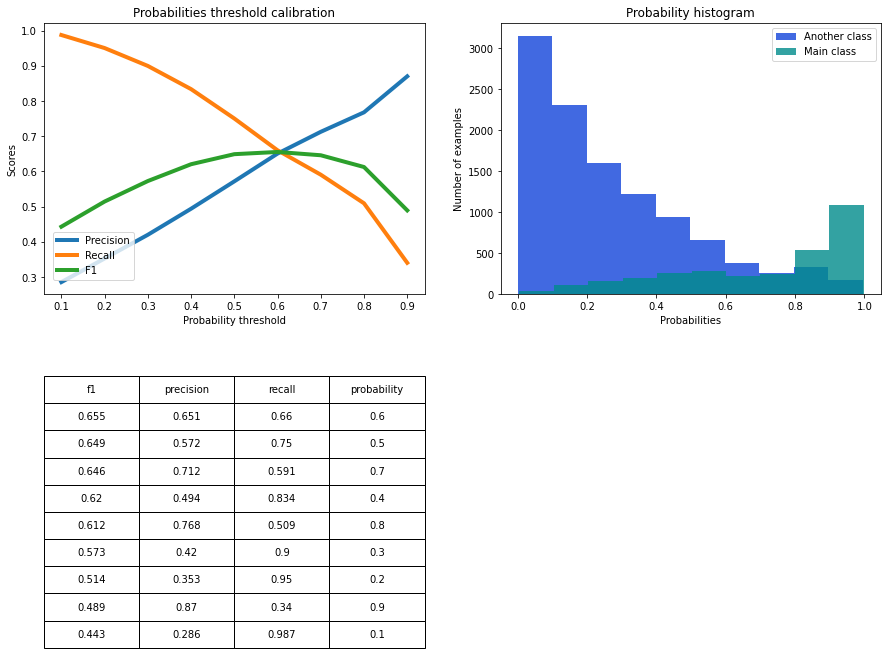

In [ ]:
show_proba_calibration_plots(catboost.predict_proba(test)[:,1], test_target)

In [ ]:
proba_preds_test = catboost.predict_proba(test)

In [ ]:
test_calibrated = np.apply_along_axis(lambda x: np.where(x[1] >= 0.6, 1, 0), axis=1, arr=proba_preds_test)

In [ ]:
report(y_test, pred_test, test_target, test_calibrated)

Train
               precision    recall  f1-score   support

           0      0.919     0.837     0.876     29785
           1      0.569     0.744     0.645      8607

    accuracy                          0.816     38392
   macro avg      0.744     0.791     0.761     38392
weighted avg      0.841     0.816     0.824     38392

Test
               precision    recall  f1-score   support

           0      0.901     0.898     0.899     11032
           1      0.651     0.660     0.655      3188

    accuracy                          0.844     14220
   macro avg      0.776     0.779     0.777     14220
weighted avg      0.845     0.844     0.845     14220

Train ROC_AUC: 0.791, Test ROC_AUC: 0.779
Train GINI: 0.581, Test GINI: 0.558
Confusion Matrix 
 col_0            0     1
RainTomorrow            
0             9902  1130
1             1084  2104


In [ ]:
catboost_next.get_cat_feature_indices()

In [ ]:
import shap
shap.initjs()
X_train = pd.DataFrame(X_train, columns=X.columns.to_list())
shap_values = catboost.get_feature_importance(train_pool, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

# visualize the first prediction's explanation
shap.force_plot(expected_value, shap_values[0,:], X.iloc[0,:])

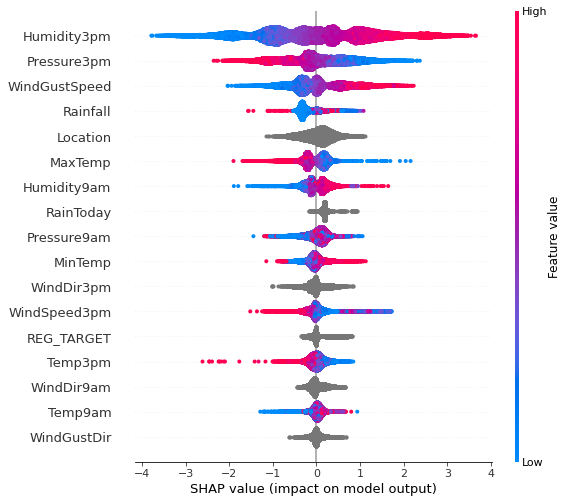

In [ ]:
shap.initjs()
shap.summary_plot(shap_values, X_train)
# high hummidity near the end of the day and low pressure near the end of the day leads impact on rain tommorow mostly